In [1]:
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import folium
from folium.plugins import HeatMap
import geopandas as gpd
import matplotlib.patches as mpatches
import contextily as ctx
from shapely.geometry import Point, box
import matplotlib.colors as mcolors

# 나눔고딕 또는 맑은 고딕으로 설정
plt.rcParams['font.family'] = 'Malgun Gothic'  # Windows 사용 시
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호 깨짐 방지

후보 행정동이 포함하는 구의 건축물대장 중 주용도코드가 3000, 4000, 7000, 9000인 것만 포함하도록 전처리

In [15]:
df_yeongtong = pd.read_csv('영통구_대지_도로명_API성공.csv')
df_paldal = pd.read_csv('팔달구_대지_도로명_API성공.csv')
df_gwonsun = pd.read_csv('권선구_대지_도로명_API성공.csv')
df_facilities = pd.concat([df_paldal, df_gwonsun], ignore_index=True)

# 인계동, 권선1동
경계를 공유하는 인계동, 권선1동은 묶어서 후보지 선정 진행

In [ ]:
# 1. 행정동 경계 불러오기
dongs = gpd.read_file("BND_ADM_DONG_PG.shp").to_crs(epsg=5181)
#dongs = dongs[dongs['ADM_CD'].astype(str) == '31012600']  # 권선1동(권선구)
#dongs = dongs[dongs['ADM_CD'].astype(str) == '31013560']  # 인계동(팔달구)
dongs = dongs[dongs['ADM_CD'].astype(str).isin(['31013560', '31012600'])] # 인계동, 권선1동
#dongs = dongs[dongs['ADM_CD'].astype(str) == '31014620'] # 광교1동 행정동 코드 (영통구)
#dongs = dongs[dongs['ADM_CD'].astype(str) == '31014660'] # 영통3동 행정동 코드 (영통구)
suwon_boundary = dongs.unary_union

# 2. 격자 생성 (50m × 50m)
xmin, ymin, xmax, ymax = suwon_boundary.bounds
cell_size = 50
cols = np.arange(xmin, xmax + cell_size, cell_size)
rows = np.arange(ymin, ymax + cell_size, cell_size)
grid_cells = [
    box(x, y, x + cell_size, y + cell_size)
    for x in cols for y in rows
    if box(x, y, x + cell_size, y + cell_size).intersects(suwon_boundary)
]
grid = gpd.GeoDataFrame({'geometry': grid_cells}, crs='EPSG:5181')

# 3. 시설 데이터 로딩 및 변환
df_facilities['주용도코드'] = df_facilities['주용도코드'].astype(int)
df_facilities['geometry'] = df_facilities.apply(lambda row: Point(row['경도'], row['위도']), axis=1)
df_facilities = gpd.GeoDataFrame(df_facilities, geometry='geometry', crs='EPSG:4326').to_crs(epsg=5181)

# 4. 단속 지점 데이터 로딩 및 변환
df_combined = pd.read_csv('단속장소_위치매핑리스트_최종.csv')
gdf_points = gpd.GeoDataFrame(
    df_combined,
    geometry=gpd.points_from_xy(df_combined['경도'], df_combined['위도']),
    crs='EPSG:4326'
).to_crs(epsg=5181)

# 5. grid 컬럼 초기화
cols = ['의료시설수', '판매시설수', '서비스업수', '음식점수']
for col in cols:
    grid[col] = 0
grid['465m_단속합'] = 0

# 6. 시설 분류 기준
code_map = {
    3000: '서비스업수',
    4000: '음식점수',
    7000: '판매시설수',
    9000: '의료시설수'
}

# 7. 465m 내 시설/단속 수 계산
for idx, row in grid.iterrows():
    center = row['geometry'].centroid
    buffer = center.buffer(465)

    nearby = df_facilities[df_facilities.geometry.within(buffer)]
    for code, col in code_map.items():
        grid.at[idx, col] = nearby[nearby['주용도코드'] == code].shape[0]

    grid.at[idx, '465m_단속합'] = gdf_points[gdf_points.geometry.within(buffer)].shape[0]

# 8. w_i 계산: 각 시설별 MinMax Scaling → 합산 → 다시 MinMax Scaling
for col in cols:
    norm_col = col + '_norm'
    grid[norm_col] = MinMaxScaler().fit_transform(grid[[col]])

grid['w_i_raw'] = grid[[col + '_norm' for col in cols]].sum(axis=1)
grid['w_i'] = MinMaxScaler().fit_transform(grid[['w_i_raw']])

# 9. a_i 계산 및 정규화
grid['a_i_raw'] = grid['465m_단속합']
grid['a_i'] = MinMaxScaler().fit_transform(grid[['a_i_raw']])

C:\Users\siam2\AppData\Local\Temp\ipykernel_27952\1888871214.py:10: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  suwon_boundary = dongs.unary_union


In [ ]:
grid # 수원시 + 권선1동 격자별 가중치 확인

geometry  의료시설수  판매시설수  서비스업수  \
0     POLYGON ((201561.993 417524.311, 201561.993 41...      0      0     39   
1     POLYGON ((201561.993 417574.311, 201561.993 41...      0      0     45   
2     POLYGON ((201561.993 417624.311, 201561.993 41...      0      0     50   
3     POLYGON ((201561.993 417674.311, 201561.993 41...      0      0     59   
4     POLYGON ((201611.993 417524.311, 201611.993 41...      0      0     55   
...                                                 ...    ...    ...    ...   
1726  POLYGON ((203611.993 418424.311, 203611.993 41...      0      0      3   
1727  POLYGON ((203611.993 419524.311, 203611.993 41...      0      0      7   
1728  POLYGON ((203611.993 419574.311, 203611.993 41...      0      0      7   
1729  POLYGON ((203611.993 419624.311, 203611.993 41...      0      0      7   
1730  POLYGON ((203661.993 419574.311, 203661.993 41...      0      0      7   

      음식점수  465m_단속합  의료시설수_norm  판매시설수_norm  서비스업수_norm  음식점수_norm   w_i_raw  \
0       73      5140         0.0         0.0    0.279070   0.336449  0.615518   
1       78      3232         0.0         0.0    0.325581   0.359813  0.685394   
2       83      3074         0.0         0.0    0.364341   0.383178  0.747519   
3       83      3703         0.0         0.0    0.434109   0.383178  0.817286   
4       87      4953         0.0         0.0    0.403101   0.401869  0.804970   
...    ...       ...         ...         ...         ...        ...       ...   
1726     9      2714         0.0         0.0    0.000000   0.037383  0.037383   
1727    14      4294         0.0         0.0    0.031008   0.060748  0.091755   
1728    12      4228         0.0         0.0    0.031008   0.051402  0.082410   
1729    11      4158         0.0         0.0    0.031008   0.046729  0.077737   
1730    10      4731         0.0         0.0    0.031008   0.042056  0.073064   

           w_i  a_i_raw       a_i  
0     0.201033     5140  0.083604  
1     0.225330     3232  0.048622  
2     0.246933     3074  0.045725  
3     0.271193     3703  0.057258  
4     0.266910     4953  0.080175  
...        ...      ...       ...  
1726  0.000000     2714  0.039125  
1727  0.018907     4294  0.068093  
1728  0.015657     4228  0.066883  
1729  0.014032     4158  0.065600  
1730  0.012407     4731  0.076105  

[1731 rows x 14 columns]

In [21]:
from pulp import LpProblem, LpVariable, lpSum, LpMaximize, LpBinary, LpStatus, value
from shapely.geometry import Point

def solve_mclp(grid, P=5, radius=465):
    # 중심 좌표 추출
    grid['centroid'] = grid.geometry.centroid
    centers = grid['centroid'].apply(lambda pt: (pt.x, pt.y)).tolist()
    
    # 커버 관계 N_i 생성
    I = list(range(len(grid)))
    J = list(range(len(grid)))
    
    N_i = {}
    for i in I:
        xi, yi = centers[i]
        N_i[i] = [j for j in J if Point(*centers[j]).distance(Point(xi, yi)) <= radius]

    # 가중치 준비
    weights = (grid['w_i'] * grid['a_i']).tolist()

    # 문제 정의
    prob = LpProblem("MCLP", LpMaximize)

    # 변수 정의
    x = LpVariable.dicts("x", J, cat=LpBinary)  # 주차장 설치 여부
    y = LpVariable.dicts("y", I, cat=LpBinary)  # 수요 커버 여부

    # 목적함수: 커버된 수요의 가중합 최대화
    prob += lpSum([weights[i] * y[i] for i in I])

    # 제약식 1: y_i는 반경 내 x_j 중 적어도 하나가 설치되어야 함
    for i in I:
        prob += lpSum([x[j] for j in N_i[i]]) >= y[i]

    # 제약식 2: 설치 가능한 주차장 개수 제한
    prob += lpSum([x[j] for j in J]) <= P

    # 최적화 수행
    prob.solve()

    # 결과 정리
    selected_indices = [j for j in J if x[j].varValue == 1]
    covered_indices = [i for i in I if y[i].varValue == 1]
    objective_value = value(prob.objective)

    return selected_indices, covered_indices, objective_value


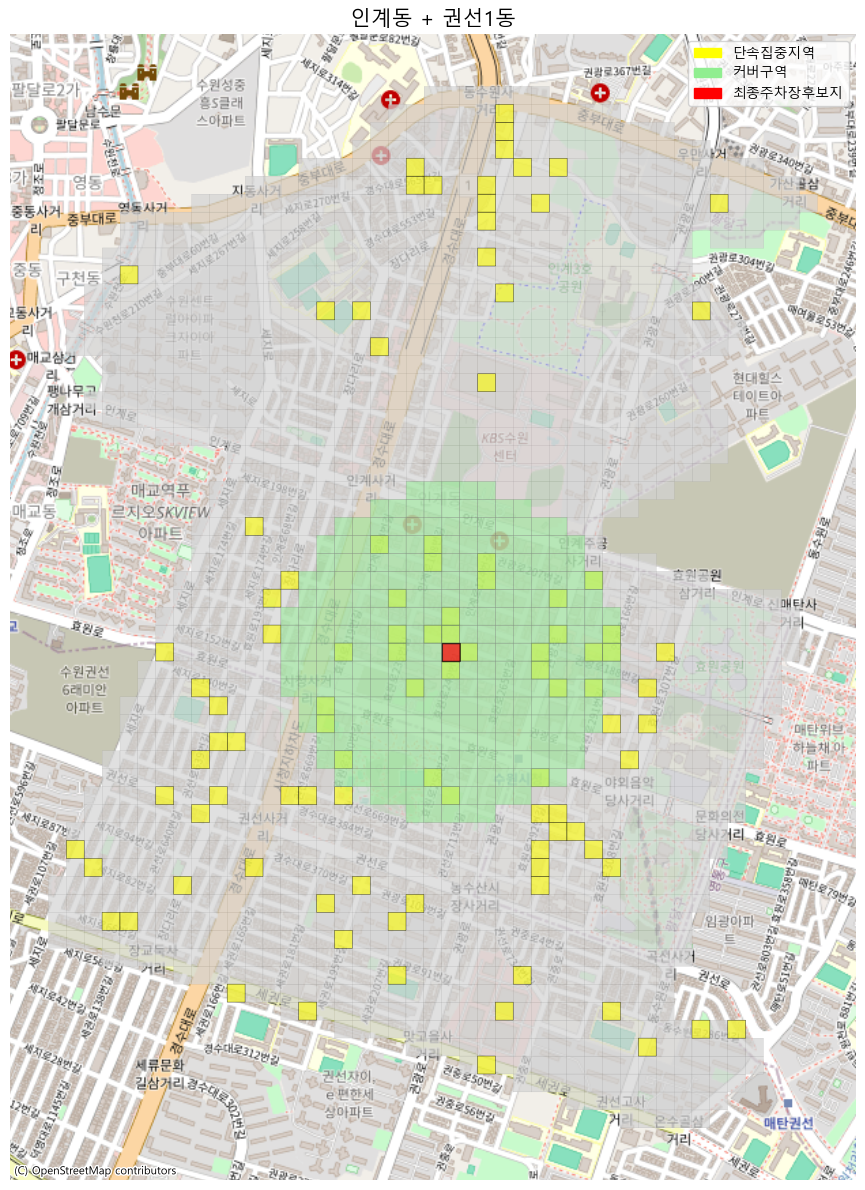

In [23]:
# 0. 선택된 결과 계산
selected, covered, obj_val = solve_mclp(grid, P=1, radius=465)

# 1. 좌표계 맞춤
grid_viz = grid.to_crs(epsg=3857)

# 2. 컬럼 준비
grid_viz['선택됨'] = 0
grid_viz['커버됨'] = 0
grid_viz['단속많음'] = 0
grid_viz.loc[selected, '선택됨'] = 1
grid_viz.loc[covered, '커버됨'] = 1

# 3. 단속건수 계산 및 표시
gdf_points = gpd.GeoDataFrame(
    df_combined,
    geometry=gpd.points_from_xy(df_combined['경도'], df_combined['위도']),
    crs='EPSG:4326'
).to_crs(epsg=5181)

# grid와 동일한 좌표계에서 공간 조인
joined = gpd.sjoin(gdf_points, grid, how='left', predicate='within')
crackdown_count = joined.groupby('index_right').size()
grid['단속건수'] = crackdown_count
grid['단속건수'] = grid['단속건수'].fillna(0).astype(int)

# 단속 많음 표시 (100 이상)
grid_viz['단속많음'] = 0
grid_viz.loc[grid['단속건수'] >= 100, '단속많음'] = 1

# 4. 시각화 시작
fig, ax = plt.subplots(figsize=(12, 12))

# 전체 격자: 연한 회색 배경
grid_viz.plot(
    facecolor='lightgrey',
    edgecolor='grey',
    linewidth=0.1,
    alpha=0.7,
    ax=ax
)

# 단속 많은 격자: 노란색
grid_viz[grid_viz['단속많음'] == 1].plot(
    color='yellow',
    edgecolor='black',
    linewidth=0.4,
    alpha=0.6,
    ax=ax
)

# 커버된 격자: 연녹색
grid_viz[grid_viz['커버됨'] == 1].plot(
    color='lightgreen',
    edgecolor='gray',
    linewidth=0.3,
    alpha=0.5,
    ax=ax
)

# 선택된 후보지: 진한 빨간색
grid_viz[grid_viz['선택됨'] == 1].plot(
    color='red',
    edgecolor='black',
    linewidth=1,
    alpha=0.7,
    ax=ax
)

legend_elements = [mpatches.Patch(color = 'yellow', label = '단속집중지역'),
                mpatches.Patch(color = 'lightgreen', label = '커버구역'),
                mpatches.Patch(color = 'red', label = '최종주차장후보지')]

# 배경지도 추가
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

# 제목 및 레이아웃
plt.title("인계동 + 권선1동", fontsize=15)
ax.legend(handles=legend_elements, loc='upper right')
plt.axis('off')
plt.tight_layout()
plt.show()

# 광교1동

In [24]:
# 1. 행정동 경계 불러오기
dongs = gpd.read_file("BND_ADM_DONG_PG.shp").to_crs(epsg=5181)
#dongs = dongs[dongs['ADM_CD'].astype(str) == '31012600']  # 권선1동(권선구)
#dongs = dongs[dongs['ADM_CD'].astype(str) == '31013560']  # 인계동(팔달구)
#dongs = dongs[dongs['ADM_CD'].astype(str).isin(['31013560', '31012600'])] # 인계동, 권선1동
dongs = dongs[dongs['ADM_CD'].astype(str) == '31014620'] # 광교1동 행정동 코드 (영통구)
#dongs = dongs[dongs['ADM_CD'].astype(str) == '31014660'] # 영통3동 행정동 코드 (영통구)
suwon_boundary = dongs.unary_union

# 2. 격자 생성 (50m × 50m)
xmin, ymin, xmax, ymax = suwon_boundary.bounds
cell_size = 50
cols = np.arange(xmin, xmax + cell_size, cell_size)
rows = np.arange(ymin, ymax + cell_size, cell_size)
grid_cells = [
    box(x, y, x + cell_size, y + cell_size)
    for x in cols for y in rows
    if box(x, y, x + cell_size, y + cell_size).intersects(suwon_boundary)
]
grid = gpd.GeoDataFrame({'geometry': grid_cells}, crs='EPSG:5181')

# 3. 시설 데이터 로딩 및 변환
df_yeongtong['주용도코드'] = df_yeongtong['주용도코드'].astype(int)
df_yeongtong['geometry'] = df_yeongtong.apply(lambda row: Point(row['경도'], row['위도']), axis=1)
df_yeongtong = gpd.GeoDataFrame(df_yeongtong, geometry='geometry', crs='EPSG:4326').to_crs(epsg=5181)

# 4. 단속 지점 데이터 로딩 및 변환
df_combined = pd.read_csv('단속장소_위치매핑리스트_최종.csv')
gdf_points = gpd.GeoDataFrame(
    df_combined,
    geometry=gpd.points_from_xy(df_combined['경도'], df_combined['위도']),
    crs='EPSG:4326'
).to_crs(epsg=5181)

# 5. grid 컬럼 초기화
cols = ['의료시설수', '판매시설수', '서비스업수', '음식점수']
for col in cols:
    grid[col] = 0
grid['465m_단속합'] = 0

# 6. 시설 분류 기준
code_map = {
    3000: '서비스업수',
    4000: '음식점수',
    7000: '판매시설수',
    9000: '의료시설수'
}

# 7. 465m 내 시설/단속 수 계산
for idx, row in grid.iterrows():
    center = row['geometry'].centroid
    buffer = center.buffer(465)

    nearby = df_yeongtong[df_yeongtong.geometry.within(buffer)]
    for code, col in code_map.items():
        grid.at[idx, col] = nearby[nearby['주용도코드'] == code].shape[0]

    grid.at[idx, '465m_단속합'] = gdf_points[gdf_points.geometry.within(buffer)].shape[0]

# 8. w_i 계산: 각 시설별 MinMax Scaling → 합산 → 다시 MinMax Scaling
for col in cols:
    norm_col = col + '_norm'
    grid[norm_col] = MinMaxScaler().fit_transform(grid[[col]])

grid['w_i_raw'] = grid[[col + '_norm' for col in cols]].sum(axis=1)
grid['w_i'] = MinMaxScaler().fit_transform(grid[['w_i_raw']])

# 9. a_i 계산 및 정규화
grid['a_i_raw'] = grid['465m_단속합']
grid['a_i'] = MinMaxScaler().fit_transform(grid[['a_i_raw']])

C:\Users\siam2\AppData\Local\Temp\ipykernel_27952\912879553.py:8: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  suwon_boundary = dongs.unary_union


In [25]:
grid # 광교1동 격자별 가중치 확인

geometry  의료시설수  판매시설수  서비스업수  \
0     POLYGON ((202921.406 422229.936, 202921.406 42...      0      0      1   
1     POLYGON ((202921.406 422279.936, 202921.406 42...      0      0      0   
2     POLYGON ((202921.406 422329.936, 202921.406 42...      0      0      0   
3     POLYGON ((202921.406 422379.936, 202921.406 42...      0      0      0   
4     POLYGON ((202921.406 422429.936, 202921.406 42...      0      0      0   
...                                                 ...    ...    ...    ...   
3368  POLYGON ((205771.406 421329.936, 205771.406 42...      0      0     12   
3369  POLYGON ((205771.406 421379.936, 205771.406 42...      0      0     12   
3370  POLYGON ((205771.406 421429.936, 205771.406 42...      0      0     11   
3371  POLYGON ((205771.406 421479.936, 205771.406 42...      0      0     11   
3372  POLYGON ((205821.406 421379.936, 205821.406 42...      0      0     12   

      음식점수  465m_단속합  의료시설수_norm  판매시설수_norm  서비스업수_norm  음식점수_norm   w_i_raw  \
0        0      2414         0.0         0.0    0.047619   0.000000  0.047619   
1        0      1629         0.0         0.0    0.000000   0.000000  0.000000   
2        0      1274         0.0         0.0    0.000000   0.000000  0.000000   
3        0       855         0.0         0.0    0.000000   0.000000  0.000000   
4        0       828         0.0         0.0    0.000000   0.000000  0.000000   
...    ...       ...         ...         ...         ...        ...       ...   
3368     4      2044         0.0         0.0    0.571429   0.222222  0.793651   
3369     4      2116         0.0         0.0    0.571429   0.222222  0.793651   
3370     4      1764         0.0         0.0    0.523810   0.222222  0.746032   
3371     4      1364         0.0         0.0    0.523810   0.222222  0.746032   
3372     4      2529         0.0         0.0    0.571429   0.222222  0.793651   

           w_i  a_i_raw       a_i  
0     0.021661     2414  0.392010  
1     0.000000     1629  0.264534  
2     0.000000     1274  0.206885  
3     0.000000      855  0.138844  
4     0.000000      828  0.134459  
...        ...      ...       ...  
3368  0.361011     2044  0.331926  
3369  0.361011     2116  0.343618  
3370  0.339350     1764  0.286457  
3371  0.339350     1364  0.221500  
3372  0.361011     2529  0.410685  

[3373 rows x 14 columns]

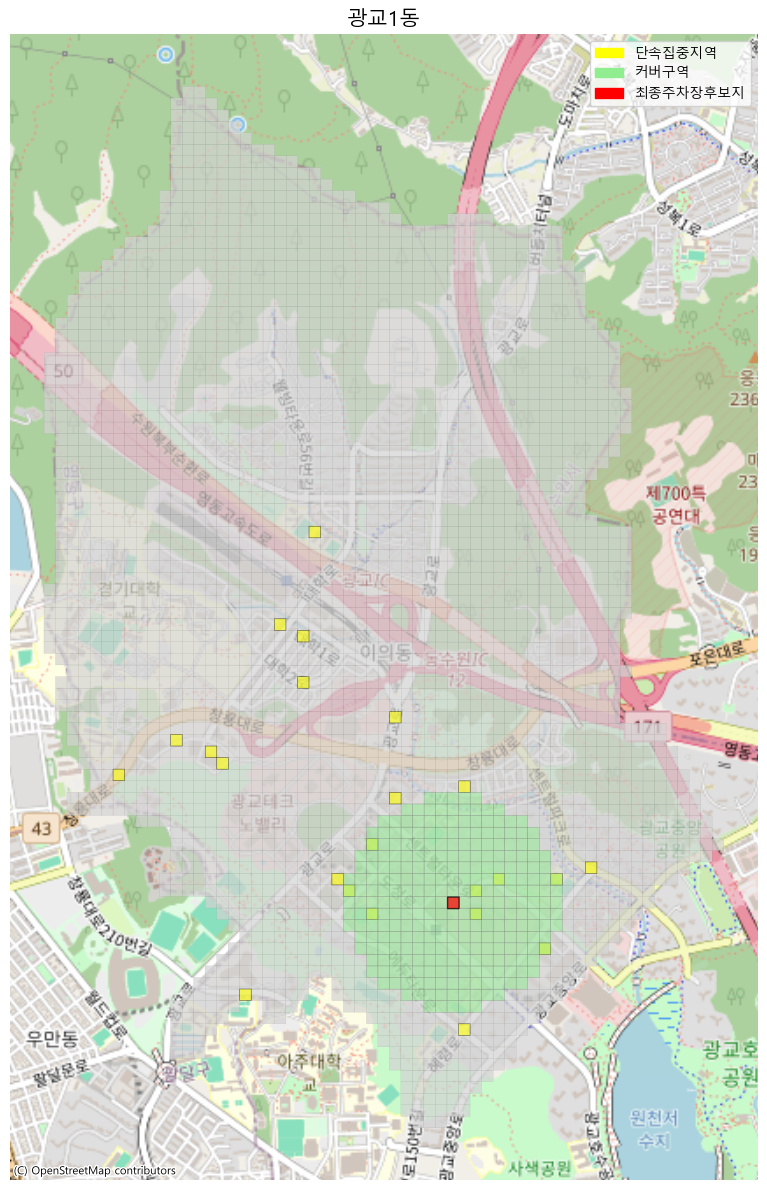

In [26]:
# 0. 선택된 결과 계산
selected, covered, obj_val = solve_mclp(grid, P=1, radius=465)

# 1. 좌표계 맞춤
grid_viz = grid.to_crs(epsg=3857)

# 2. 컬럼 준비
grid_viz['선택됨'] = 0
grid_viz['커버됨'] = 0
grid_viz['단속많음'] = 0
grid_viz.loc[selected, '선택됨'] = 1
grid_viz.loc[covered, '커버됨'] = 1

# 3. 단속건수 계산 및 표시
gdf_points = gpd.GeoDataFrame(
    df_combined,
    geometry=gpd.points_from_xy(df_combined['경도'], df_combined['위도']),
    crs='EPSG:4326'
).to_crs(epsg=5181)

# grid와 동일한 좌표계에서 공간 조인
joined = gpd.sjoin(gdf_points, grid, how='left', predicate='within')
crackdown_count = joined.groupby('index_right').size()
grid['단속건수'] = crackdown_count
grid['단속건수'] = grid['단속건수'].fillna(0).astype(int)

# 단속 많음 표시 (100 이상)
grid_viz['단속많음'] = 0
grid_viz.loc[grid['단속건수'] >= 100, '단속많음'] = 1

# 4. 시각화 시작
fig, ax = plt.subplots(figsize=(12, 12))

# 전체 격자: 연한 회색 배경
grid_viz.plot(
    facecolor='lightgrey',
    edgecolor='grey',
    linewidth=0.1,
    alpha=0.7,
    ax=ax
)

# 단속 많은 격자: 노란색
grid_viz[grid_viz['단속많음'] == 1].plot(
    color='yellow',
    edgecolor='black',
    linewidth=0.4,
    alpha=0.6,
    ax=ax
)

# 커버된 격자: 연녹색
grid_viz[grid_viz['커버됨'] == 1].plot(
    color='lightgreen',
    edgecolor='gray',
    linewidth=0.3,
    alpha=0.5,
    ax=ax
)

# 선택된 후보지: 진한 빨간색
grid_viz[grid_viz['선택됨'] == 1].plot(
    color='red',
    edgecolor='black',
    linewidth=1,
    alpha=0.7,
    ax=ax
)

legend_elements = [mpatches.Patch(color = 'yellow', label = '단속집중지역'),
                mpatches.Patch(color = 'lightgreen', label = '커버구역'),
                mpatches.Patch(color = 'red', label = '최종주차장후보지')]

# 배경지도 추가
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

# 제목 및 레이아웃
plt.title("광교1동", fontsize=15)
ax.legend(handles=legend_elements, loc='upper right')
plt.axis('off')
plt.tight_layout()
plt.show()

# 영통3동

In [27]:
# 1. 행정동 경계 불러오기
dongs = gpd.read_file("BND_ADM_DONG_PG.shp").to_crs(epsg=5181)
#dongs = dongs[dongs['ADM_CD'].astype(str) == '31012600']  # 권선1동(권선구)
#dongs = dongs[dongs['ADM_CD'].astype(str) == '31013560']  # 인계동(팔달구)
#dongs = dongs[dongs['ADM_CD'].astype(str).isin(['31013560', '31012600'])] # 인계동, 권선1동
#dongs = dongs[dongs['ADM_CD'].astype(str) == '31014620'] # 광교1동 행정동 코드 (영통구)
dongs = dongs[dongs['ADM_CD'].astype(str) == '31014660'] # 영통3동 행정동 코드 (영통구)
suwon_boundary = dongs.unary_union

# 2. 격자 생성 (50m × 50m)
xmin, ymin, xmax, ymax = suwon_boundary.bounds
cell_size = 50
cols = np.arange(xmin, xmax + cell_size, cell_size)
rows = np.arange(ymin, ymax + cell_size, cell_size)
grid_cells = [
    box(x, y, x + cell_size, y + cell_size)
    for x in cols for y in rows
    if box(x, y, x + cell_size, y + cell_size).intersects(suwon_boundary)
]
grid = gpd.GeoDataFrame({'geometry': grid_cells}, crs='EPSG:5181')

# 3. 시설 데이터 로딩 및 변환
df_yeongtong['주용도코드'] = df_yeongtong['주용도코드'].astype(int)
df_yeongtong['geometry'] = df_yeongtong.apply(lambda row: Point(row['경도'], row['위도']), axis=1)
df_yeongtong = gpd.GeoDataFrame(df_yeongtong, geometry='geometry', crs='EPSG:4326').to_crs(epsg=5181)

# 4. 단속 지점 데이터 로딩 및 변환
df_combined = pd.read_csv('단속장소_위치매핑리스트_최종.csv')
gdf_points = gpd.GeoDataFrame(
    df_combined,
    geometry=gpd.points_from_xy(df_combined['경도'], df_combined['위도']),
    crs='EPSG:4326'
).to_crs(epsg=5181)

# 5. grid 컬럼 초기화
cols = ['의료시설수', '판매시설수', '서비스업수', '음식점수']
for col in cols:
    grid[col] = 0
grid['465m_단속합'] = 0

# 6. 시설 분류 기준
code_map = {
    3000: '서비스업수',
    4000: '음식점수',
    7000: '판매시설수',
    9000: '의료시설수'
}

# 7. 465m 내 시설/단속 수 계산
for idx, row in grid.iterrows():
    center = row['geometry'].centroid
    buffer = center.buffer(465)

    nearby = df_yeongtong[df_yeongtong.geometry.within(buffer)]
    for code, col in code_map.items():
        grid.at[idx, col] = nearby[nearby['주용도코드'] == code].shape[0]

    grid.at[idx, '465m_단속합'] = gdf_points[gdf_points.geometry.within(buffer)].shape[0]

# 8. w_i 계산: 각 시설별 MinMax Scaling → 합산 → 다시 MinMax Scaling
for col in cols:
    norm_col = col + '_norm'
    grid[norm_col] = MinMaxScaler().fit_transform(grid[[col]])

grid['w_i_raw'] = grid[[col + '_norm' for col in cols]].sum(axis=1)
grid['w_i'] = MinMaxScaler().fit_transform(grid[['w_i_raw']])

# 9. a_i 계산 및 정규화
grid['a_i_raw'] = grid['465m_단속합']
grid['a_i'] = MinMaxScaler().fit_transform(grid[['a_i_raw']])

C:\Users\siam2\AppData\Local\Temp\ipykernel_27952\3837465451.py:8: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  suwon_boundary = dongs.unary_union


In [28]:
grid

geometry  의료시설수  판매시설수  서비스업수  \
0    POLYGON ((205458.731 416959.11, 205458.731 417...      1      0     16   
1    POLYGON ((205458.731 417009.11, 205458.731 417...      0      0     16   
2    POLYGON ((205458.731 417059.11, 205458.731 417...      0      0     16   
3    POLYGON ((205508.731 416909.11, 205508.731 416...      1      0     16   
4    POLYGON ((205508.731 416959.11, 205508.731 417...      1      0     15   
..                                                 ...    ...    ...    ...   
766  POLYGON ((207358.731 417309.11, 207358.731 417...      0      0      4   
767  POLYGON ((207408.731 417259.11, 207408.731 417...      0      0      3   
768  POLYGON ((207408.731 417309.11, 207408.731 417...      0      0      3   
769  POLYGON ((207458.731 417259.11, 207458.731 417...      0      0      1   
770  POLYGON ((207458.731 417309.11, 207458.731 417...      0      0      1   

     음식점수  465m_단속합  의료시설수_norm  판매시설수_norm  서비스업수_norm  음식점수_norm   w_i_raw  \
0      94      2378         1.0         0.0    0.727273   0.676259  2.403532   
1     102      2385         0.0         0.0    0.727273   0.733813  1.461086   
2     100      2179         0.0         0.0    0.727273   0.719424  1.446697   
3      84      2359         1.0         0.0    0.727273   0.604317  2.331589   
4      87      2380         1.0         0.0    0.681818   0.625899  2.307717   
..    ...       ...         ...         ...         ...        ...       ...   
766    14      1026         0.0         0.0    0.181818   0.100719  0.282538   
767    10      1010         0.0         0.0    0.136364   0.071942  0.208306   
768    10      1006         0.0         0.0    0.136364   0.071942  0.208306   
769     7       999         0.0         0.0    0.045455   0.050360  0.095814   
770     6       997         0.0         0.0    0.045455   0.043165  0.088620   

          w_i  a_i_raw       a_i  
0    0.697377     2378  0.250796  
1    0.422282     2385  0.251565  
2    0.418083     2179  0.228936  
3    0.676377     2359  0.248709  
4    0.669409     2380  0.251016  
..        ...      ...       ...  
766  0.078271     1026  0.102274  
767  0.056603     1010  0.100516  
768  0.056603     1006  0.100077  
769  0.023768      999  0.099308  
770  0.021668      997  0.099088  

[771 rows x 14 columns]

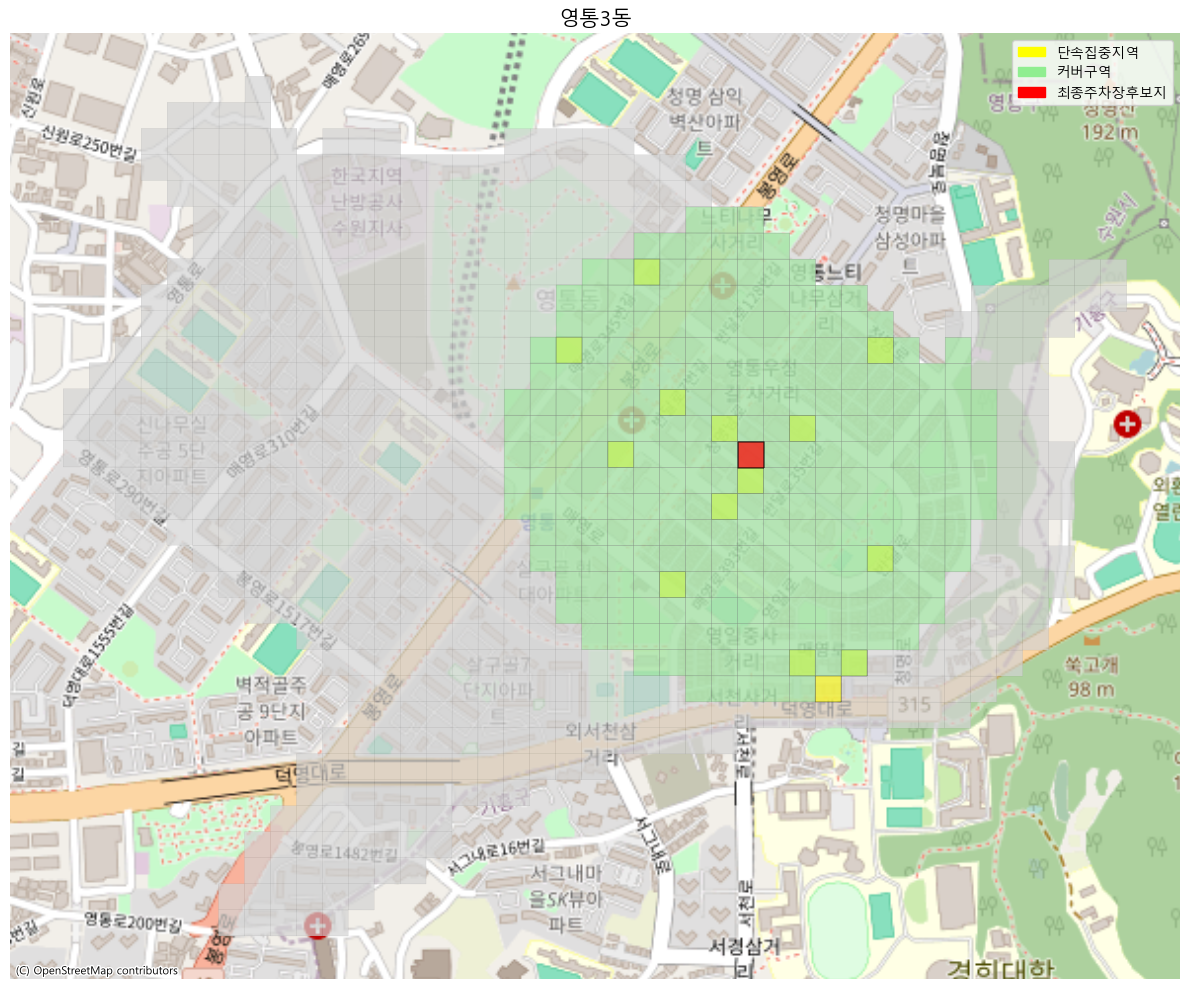

In [29]:
# 0. 선택된 결과 계산
selected, covered, obj_val = solve_mclp(grid, P=1, radius=465)

# 1. 좌표계 맞춤
grid_viz = grid.to_crs(epsg=3857)

# 2. 컬럼 준비
grid_viz['선택됨'] = 0
grid_viz['커버됨'] = 0
grid_viz['단속많음'] = 0
grid_viz.loc[selected, '선택됨'] = 1
grid_viz.loc[covered, '커버됨'] = 1

# 3. 단속건수 계산 및 표시
gdf_points = gpd.GeoDataFrame(
    df_combined,
    geometry=gpd.points_from_xy(df_combined['경도'], df_combined['위도']),
    crs='EPSG:4326'
).to_crs(epsg=5181)

# grid와 동일한 좌표계에서 공간 조인
joined = gpd.sjoin(gdf_points, grid, how='left', predicate='within')
crackdown_count = joined.groupby('index_right').size()
grid['단속건수'] = crackdown_count
grid['단속건수'] = grid['단속건수'].fillna(0).astype(int)

# 단속 많음 표시 (100 이상)
grid_viz['단속많음'] = 0
grid_viz.loc[grid['단속건수'] >= 100, '단속많음'] = 1

# 4. 시각화 시작
fig, ax = plt.subplots(figsize=(12, 12))

# 전체 격자: 연한 회색 배경
grid_viz.plot(
    facecolor='lightgrey',
    edgecolor='grey',
    linewidth=0.1,
    alpha=0.7,
    ax=ax
)

# 단속 많은 격자: 노란색
grid_viz[grid_viz['단속많음'] == 1].plot(
    color='yellow',
    edgecolor='black',
    linewidth=0.4,
    alpha=0.6,
    ax=ax
)

# 커버된 격자: 연녹색
grid_viz[grid_viz['커버됨'] == 1].plot(
    color='lightgreen',
    edgecolor='gray',
    linewidth=0.3,
    alpha=0.5,
    ax=ax
)

# 선택된 후보지: 진한 빨간색
grid_viz[grid_viz['선택됨'] == 1].plot(
    color='red',
    edgecolor='black',
    linewidth=1,
    alpha=0.7,
    ax=ax
)

legend_elements = [mpatches.Patch(color = 'yellow', label = '단속집중지역'),
                mpatches.Patch(color = 'lightgreen', label = '커버구역'),
                mpatches.Patch(color = 'red', label = '최종주차장후보지')]

# 배경지도 추가
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

# 제목 및 레이아웃
plt.title("영통3동", fontsize=15)
ax.legend(handles=legend_elements, loc='upper right')
plt.axis('off')
plt.tight_layout()
plt.show()